### <center> Elektrotehnički fakultet </center>
### <center> Univerzitet u Beogradu </center> ###

![alt text](grb.jfif "Title")


## <center> Mašinsko učenje </center> ##
# <center>Domaći zadatak - Izbor odlika, stabla, ansambli</center> #


#### <center> Jovana Savic 2020/3423 </center>

# 1. Izbor prediktora

Potrebno je izabrati dva najbolja prediktora na dva načina:

- Na osnovu koeficijenata korelacije sa izlaznom promenljivom
- Pomocu omotač algoritama korišćenjem logističke regresije bez regularizacije kao klasifikator.

Podaci su u fajlu `data_1.csv`.

Za učitavanje i standardizaciju podataka se koristi funkcija definisana u fajlu `util.py`. 

In [1]:
from util import read_and_standardize_data

X, y = read_and_standardize_data(filename="data_1.csv", num_of_features=13)

## 1.1. Izbor prediktora na osnovu koeficijenta korelacije sa izlaznom promenljivom

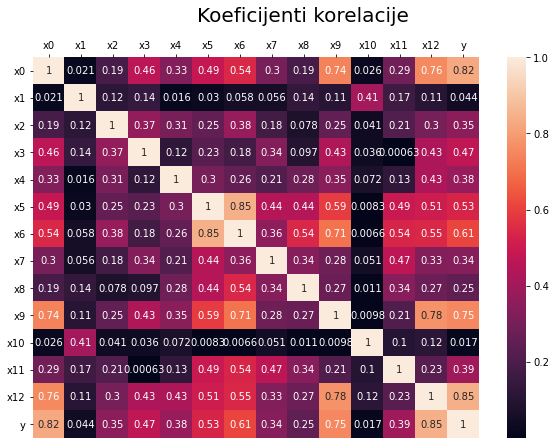

In [2]:
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

corr_coeff = abs(np.corrcoef(X, y, rowvar=False))

labels = []
for i in range(corr_coeff.shape[0] - 1):
    labels.append('x'+str(i))
labels.append('y')

plt.figure(figsize = (10,7))
plt.suptitle("Koeficijenti korelacije", fontsize=20)
ax=sn.heatmap(corr_coeff, annot=True, xticklabels = labels, yticklabels = labels)
plt.yticks(rotation=0) 
ax.xaxis.tick_top() 
ax.xaxis.set_label_position('top')
plt.show()

Na osnovu koeficijenata korelacije koji su dobijeni u obzir dolaze prediktori $x_0$, $x_9$ i $x_{12}$ sa svojim koeficijentima

$$\rho (x_0, y) = 0.82 \\ \rho (x_9, y) = 0.75 \\ \rho (x_{12}, y) = 0.85$$

Koeficijenti korelacije izmedju ovih parametara su veoma slicni: 

$$\rho (x_0, x_9) = 0.74 \\ \rho (x_0, x_{12}) = 0.76 \\ \rho (x_9, x_{12}) = 0.78$$ 

Zato međusobni koeficijenti korelacije nisu u ovom slučaju preterano korisni. Da su neka dva kandidata imala veliki koeficijent korelacije jedan sa drugim, tada bi biranje prediktora bilo dosta očiglednije. Bilo bi jasno da ta dva prediktora nose praktično istu informaciju i bilo bi dovoljno uzeti samo jedan od njih.

Ono što takođe ovde nije očigledno je kako bi se određeni prediktori ponašali u kombinaciji jedan sa drugim.

Prema tome, nije uopšte očigledno koja dva prediktora jesu najbolji par.

Srećom, potrebna su nam samo dva prediktora, pa pošto to možemo da prikažemo grafički, nije teško da zapravo pogledamo kako izlazi izgledaju u ravni prediktora u zavisnosti od toga koje smo parove prediktora izabrali.

In [3]:
def plot_predictors(X, y, candidates):
    
    n = len(candidates)
    fig, axs = plt.subplots(n * (n - 1) // 2, figsize=(7,12))
    fig.suptitle('Izlazi u ravni prediktora', fontsize=20)
    
    counter = 0
    for i in range(n):
        for j in range(i+1, n):
            x1, x2 = candidates[i], candidates[j]
            X_ = X[:, [x1, x2]]
            axs[counter].scatter(X_[:,0], X_[:,1], c=y, cmap='PiYG', lw=0, alpha=0.75)
            axs[counter].set_title("Prediktori x" + str(x1) + " i x" + str(x2))
            
            counter += 1

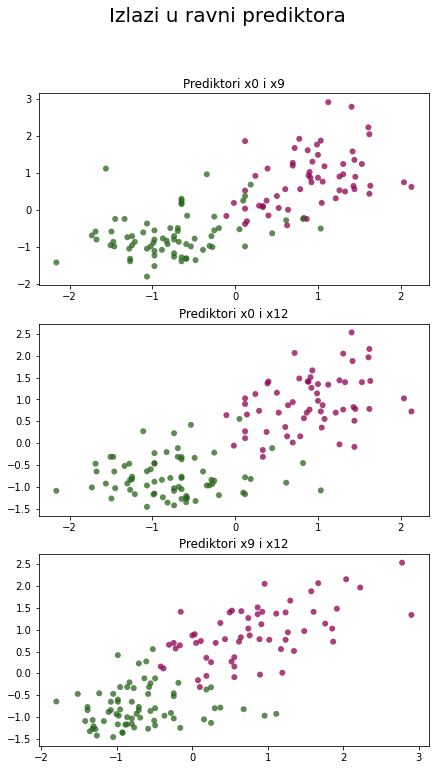

In [4]:
candidates = [0, 9, 12]
plot_predictors(X, y, candidates)

Sa slike se vidi da je $x_9$ i $x_{12}$ najbolja kombinacija jer je tada najmanje preklapanja između odbiraka različitih klasa (mada ni par $x_0$ i $x_{12}$ nije toliko loš, ali deluje kao da podaci koji se preklapaju nisu izuzeci).  

## 1.2. Biranje prediktora korišćenjem omotač algoritma

Biranje prediktora korišćenjem omotač algoritma podrazumeva da u svakoj iteraciji dodajemo (oduzimamo) onaj prediktor koji kada ga dodamo (oduzmemo) daje najbolje (najmanje kvari) rezultate pri unakrsnoj validaciji. Početni skup prediktora je prazan skup (skup svih prediktora). 

Pošto su nam potrebna dva prediktora najrazumnije je početi sa praznim skupom prediktora. Na ovaj način se ipak ne garantuje da ćemo izabrati najbolji par prediktora (moguće je da neka dva prediktora u kombinaciji daju bolje rezultate, ali da jedan od njih samostalno daje loše, pa da bude odbačen). U konkretnom slučaju imamo jako malo prediktora, takođe znamo da su nam potrebna samo dva, pa nije nerazumno modifikovati pomenuti algoritam i zapravo proveriti sve moguće parove i na taj način odrediti onaj koji je zaista najbolji.

Pošto je u ovom domaćem zadatku potrebno dosta puta prikazati rezultate unakrsne validacije za tu svrhu je napravljena funkcija `plot_cross_validation_results` koja se nalazi u fajlu `util_plot.py`. Da bi ona mogla da se primeni i ovde napravićemo novi estimator baziran na logističkoj regresiji koji će kao hiper-parametar imati i prediktore koji se koriste.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

class FeatureLogisticRegression(BaseEstimator, ClassifierMixin):
    
    def __init__(self, subestimator=LogisticRegression(penalty='none', 
                        fit_intercept = False,
                        multi_class = 'auto',
                        max_iter = 1000,
                        tol = 1e-5), 
                 features=None):
        
             self.subestimator = subestimator
             self.features = features
        
    def get_params(self, deep=True):
        return {"features": self.features}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def fit(self, X, y):
        
        if self.features is None:
            self.X_ = X
        else :
            assert max(self.features) < X.shape[1]         
            assert min(self.features) >= 0
            self.X_ = X[:, self.features]

        self.classes_ = unique_labels(y)
        self.y_ = y
        
        self.subestimator.fit(self.X_, y)
        
        return self
    
    def predict(self, X):
        
        check_is_fitted(self)
        X = check_array(X)
        
        if self.features is None:
            X = X
        else :
            assert max(self.features) < X.shape[1]
            assert min(self.features) >= 0
            X = X[:, self.features]
        
        return self.subestimator.predict(X)
    
    def _more_tags(self):
        return {'no_validation': True}

In [6]:
from sklearn.utils.estimator_checks import check_estimator
check_estimator(FeatureLogisticRegression())

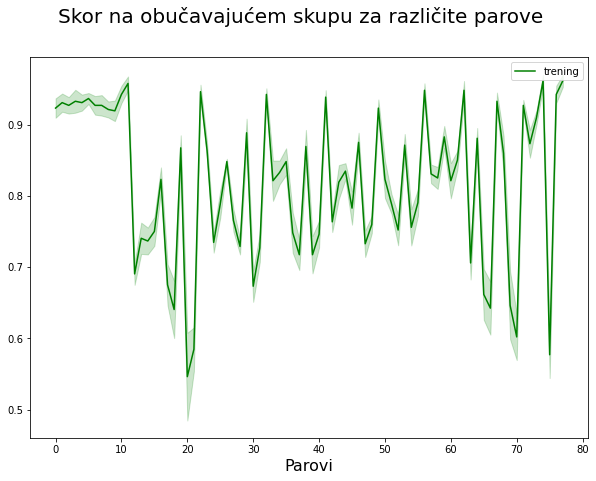

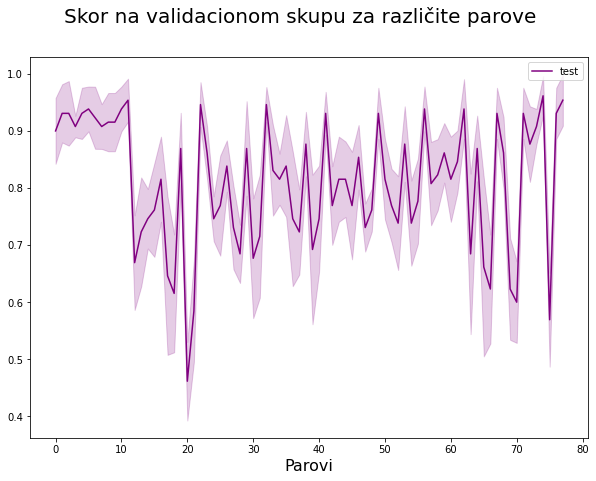

In [7]:
from util_plot import plot_cross_validation_results
from itertools import combinations 

pairs = [list(elem) for elem in list(combinations(range(X.shape[1]), 2))]

plt.figure(num="wrapper_train", figsize = (10,7))
plt.suptitle("Skor na obučavajućem skupu za različite parove", fontsize=20)
plt.xlabel("Parovi", fontsize=16)

plt.figure(num="wrapper_test", figsize = (10,7))
plt.suptitle("Skor na validacionom skupu za različite parove", fontsize=20)
plt.xlabel("Parovi", fontsize=16)
    
test_scores_mean, test_scores_std, _, _ = plot_cross_validation_results(X=X, y=y, model=FeatureLogisticRegression(), 
                                                                  param_name = 'features', 
                                                                  param_range = pairs, 
                                                                  scoring = 'accuracy', 
                                                                  folds = 5, 
                                                                  fig_test = "wrapper_test", 
                                                                  fig_train = "wrapper_train", 
                                                                  label = "", 
                                                                  color = "purple", 
                                                                  color_train="green", 
                                                                  std=True)


Sada možemo da proverimo koji to parovi daju tačnost na validacionom skupu u proseku iznad 95%. 

In [8]:
best_acc = np.argwhere(test_scores_mean > 0.95)
best_pairs = [(pairs[i[0]], round(test_scores_mean[i[0]], 4), round(test_scores_std[i[0]], 4), 
               round(test_scores_mean[i[0]], 3) - round(test_scores_std[i[0]], 3)) for i in best_acc.tolist()]

Prikazujemo ime para, srednju vrednost tačnosti na validacionom skupu, njenu standardnu devijaciju i donju granicu.

In [9]:
best_pairs

[([0, 12], 0.9538, 0.0377, 0.9159999999999999),
 ([9, 12], 0.9615, 0.0344, 0.9279999999999999),
 ([11, 12], 0.9538, 0.0449, 0.9089999999999999)]

Možemo da primetimo i da su parametri $x_0$, $x_9$ i $x_{12}$ koji su dobijeni kao najznačajniji posmatranjem koeficijenta korelacije takođe u rešenju. Pri tome parametar $x_{12}$ čiji je koeficijent korelacije sa izlazom najveći i figuriše u svakom paru koji ima dobru tačnost. 

Ponovo, kao par prediktora biramo $x_9$ i $x_{12}$ koji ima najbolju prosečnu tačnost i najmanju varijansu.

## 1.3. Zaključak

Oba načina su dala isti par prediktora kao najbolji, mada su oba pristupa malo modifikovana u skladu sa konkretnim problemom.

Koeficijenti korelacije pokazali kao odličan način da izdvojimo bitno od nebitnog, ali onda kada izdvojimo najbolje kandidate, videli smo da nije baš idealno osloniti se slepo na koeficijente korelacije. Osim toga, koeficijent korelacije može da ukaže na linearnu zavisnost, ali ne i neku složeniju. 

Sa druge strane, metod omotač algoritma nije ograničen na linearnu zavisnost (možemo da koristimo i lažne prediktore, mada to proces čini dosta numerički složenijim), ali jeste i u najjednostavnijem slučaju prilično numerički zahtevan. 

Kombinacijom ovih i drugih metoda možemo da se prilagodimo konkretnom problemu i da pronađemo odgovarajuće prediktore. Na primer, koeficijente korelacije možemo da koristimo kao grubu procenu toga šta najverovatnije ne dolazi u obzir, a da potom primenimo metodu omotač algoritma, na sada mnogo manji skup potencijalnih prediktora, za određivanje onih koji su najbitniji. Naravno, nije na odmet iskoristiti i svaku priliku koju daje konkretan problem (kao što smo ovde iskoristili činjenicu da su nam potrebna samo dva prediktora). 

Velika prednost ovih metoda u odnosu na, na primer PCA, je u tome što koristimo one prediktore koje smo prikupili - ne sintetišemo nove prediktore na osnovu njih. Prediktori koje imamo su uglavnom konkretne stvari koje možemo da merimo, pa zadržavanje istih pomaže da kasnije mnogo bolje interpretiramo model koji imamo. 

# 2. Stabla odlučivanja

Potrebno je obučiti klasifikaciono stablo za prethodno izabrani najbolji par prediktora. 

- Skicirati zavisnost grešaka klasifikacije na trening i validacionom skupu u zavisnosti od maksimalne dubine stabla
- Skicirati granicu odlučivanja u ravni prediktora za tri različite dubine. 

## 2.1. Zavisnost greške klasifikacije od maksimalne dubine stabla

Ispod je prikazana zavisnost greške klasifikacije obučavajućeg i validacionog skupa za različite dubine stabla. Ispostavlja se da je maksimalna dubina stabla koja može da se dobije 3, pa su granice izabrane u skladu sa tim.

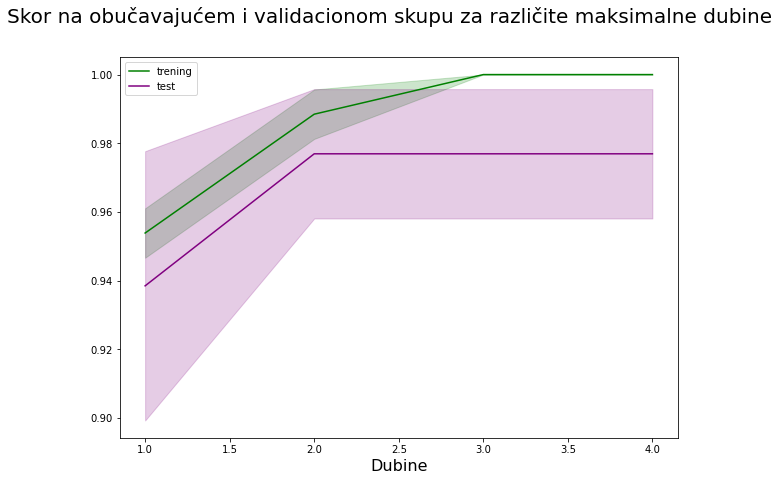

In [10]:
from sklearn.tree import DecisionTreeClassifier

X = X[:, [9, 12]]
depths = np.arange(1,5)

plt.figure(num="descision_tree", figsize = (10,7))
plt.suptitle("Skor na obučavajućem i validacionom skupu za različite maksimalne dubine", fontsize=20)
plt.xlabel("Dubine", fontsize=16)
    
test_scores_mean, test_scores_std, _, _ = plot_cross_validation_results(X=X, y=y, 
                                                                      model=DecisionTreeClassifier(criterion="entropy"), 
                                                                      param_name = 'max_depth', 
                                                                      param_range = depths, 
                                                                      scoring = 'accuracy', 
                                                                      folds = 5, 
                                                                      fig_test = "descision_tree", 
                                                                      fig_train = "descision_tree", 
                                                                      label = "", 
                                                                      color = "purple", 
                                                                      color_train="green", 
                                                                      std=True)


Vidimo da je za dubine 1 i 2 razlika između tačnosti na validacionom i obučavajućem skupu dosta manja nego za dubinu koja je veča od toga. Ovo je znak da se za veće maksimalne dubine najverovanije dešava preobučavanje modela. Sa druge strane, tačnost na validacionom skupu je najbolja za maksimalnu dubinu bar 2. 

## 2.2. Granice odlučivanja u ravni prediktora za različite maksimalne dubine stabla

Ispod je definisana funkcija koja prikazuje podatke i granicu odluke za različite dubine stabla.

In [11]:
def plot_desicion_tree_boundaries(X_train, y_train, X_test, y_test, max_depth):
    
    model = DecisionTreeClassifier(criterion = "entropy", max_depth=max_depth)
    model.fit(X_train, y_train)
    
    plt.figure(figsize = (12,9))
    plt.suptitle("Granica odluke i klasifikacija odbiraka za maksimalnu dubinu " + str(max_depth), fontsize=20)
    
    plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='coolwarm_r', lw=0, alpha=0.75, marker = "s", label="trening")
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm_r', lw=0, alpha=0.75, label="test")
    
    xmin, xmax, ymin, ymax = plt.axis()
    xx, yy = np.meshgrid(
        np.linspace(xmin, xmax, num=100, endpoint=True), 
        np.linspace(ymin, ymax, num=100, endpoint=True))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.1, cmap='coolwarm_r')
    
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    plt.xlabel("Tačnost na validacionom skupu = " + str(round(accuracy_score(y_test, y_test_pred), 4)) + 
               ", Tačnost na obučavajućem skupu " + str(round(accuracy_score(y_train, y_train_pred), 4)),
              fontsize=16)
    
    plt.legend(loc="best")
    plt.show()
    
    plt.figure(figsize = (9,9))
    tree.plot_tree(model, filled=True) 
    

In [12]:
from sklearn import tree
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=22)

Ispod prikazujemo granice odluke i klasifkaciju odbiraka za različite maksimalne dubine zajedno sa dobijenim stablom odlučivanja. Klasi 0 odgovaraju tople boje na grafiku i u stablu odlučivanja, dok klasi 1 odgovaraju hladne boje.

### 2.2.1. Nedovoljno obučeno stablo

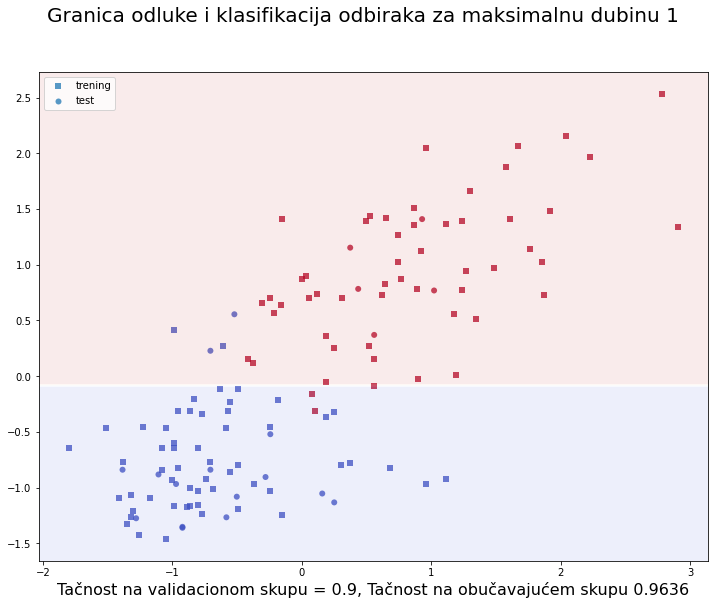

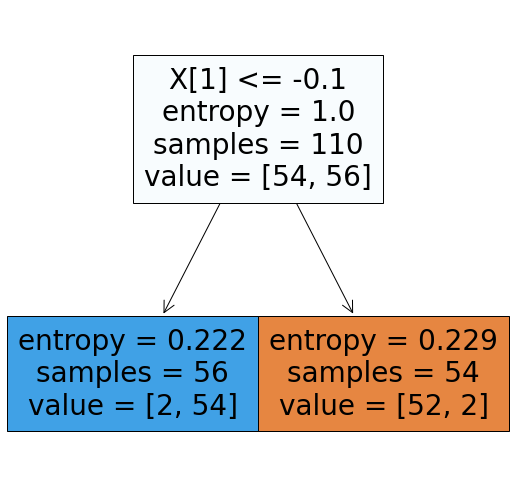

In [13]:
plot_desicion_tree_boundaries(X_train, y_train, X_test, y_test, 1)

Sa slike je očigledno da je stablo podobučeno, ali je model imao sreće da se većina najproblematičnijih primera ne nađe u validacionom skupu. 

### 2.2.2. Dobro obučeno stablo

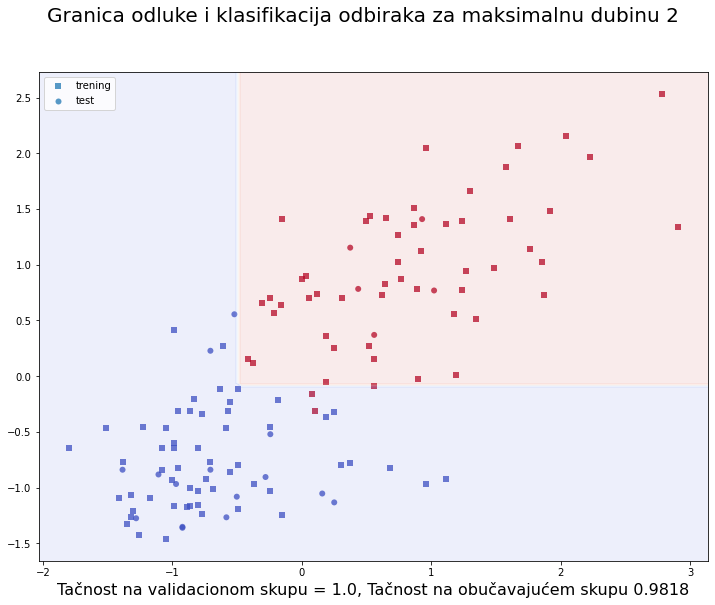

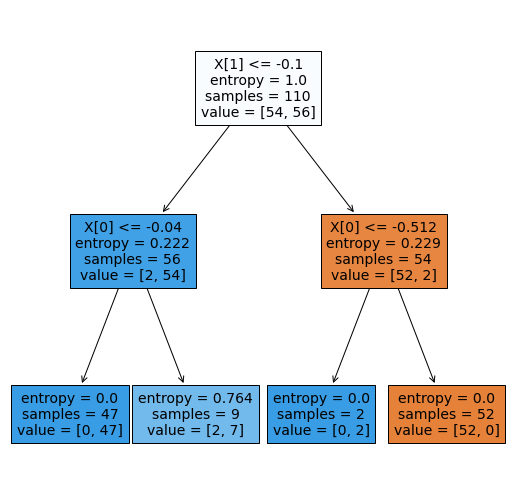

In [14]:
plot_desicion_tree_boundaries(X_train, y_train, X_test, y_test, 2)

Prikazani model je najbolji i granica odluke je najprirodnija granica koja može da se očekuje od stabla odlučivanja. Postoje primeri koji su na pogrešnoj strani odluke, ali nije nerazumno pretpostaviti da se radi o izuzecima koje bi imalo smisla ignorisati.

### 2.2.3. Preobučeno stablo

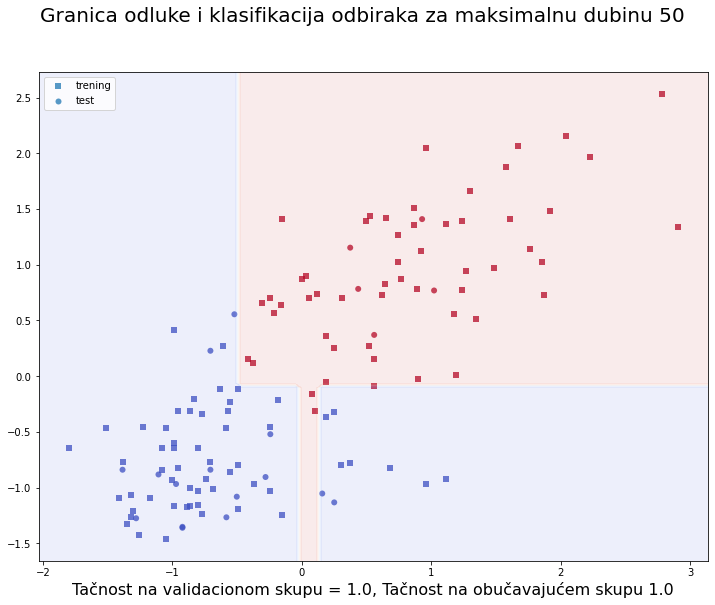

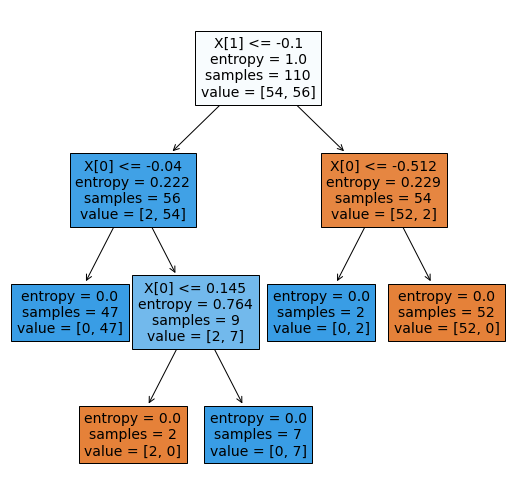

In [16]:
plot_desicion_tree_boundaries(X_train, y_train, X_test, y_test, 50)

Ovde je namerno izabrana značajno veća maksimalna dubina da bi se pokazalo da se ne dobija stablo veće dubine od 3. Iako su sada svi odbirci sa odgovarajuće strane granice odluke, čini se da je ovo stablo preobučeno jer su primeri koji su najverovatnije izuzeci uzeti u obzir. Granica odluke se očigledno previše prilagođava primerima koji su izuzeci i vrlo verovatno da ova oblast pripada plavoj klasi i da bi to dovelo do veće greške na novim podacima.

## 2.3. Zaključak

Maksimalna dubina stabla je parametar koji kontroliše da li će naš model biti preobučen ili podobučen. Podobučeno stablo izgleda praktično isto bez obzira na to kako su podaci podeljeni u obučavajući i validacioni skup. Međutim, preobučeno stablo za različite podele na obučavajući i validacioni skup daje dosta drugačije rezultate. Često, dobijena granica odluke za preobučeno stablo izgleda potpuno razumno i na prvi pogled može da se čini kao da je i bolja od one u kojoj je maksimalna dubina optimalna, što je odlično pokazuje koliko je zapravo značajna unakrsna validacija kada imamo jako mali skup podataka.

Vidimo takođe da je stablo jako osetljivo na parametar maksimalne dubine i da i mala promena predstavlja granicu između nedovoljno obučenog i preobučenog stabla. Osim toga, vidimo da su granice odluke prilično grube, pa to može da bude prilično loše u zavisnosti od toga kakvi su podaci. 

Velika prednost klasifikacionog stabla je u tome što od svih klasifikatora daje najbolju interpretaciju toga kako ulazni podaci utiču na željeni izlaz. Ako pogledamo širu sliku problema klasifikacije, često nemamo samo izolovan problem klasifikacije, već među ishodima koje klasifikujemo imamo i one koji su poželjni i nepoželjni, i tada i gruba procena može biti jako korisna ako je jednostavna.

Da smo koristili, na primer, metod nosećih vektora sa Gausovim kernelom, vrlo verovatno da bismo bez problema formirali mnogo bolju granicu odluke, ali iako tačnji, takav model bismo teško iskoristili da saznamo nešto novo. 

U zavisnosti od toga šta predstavljaju naši podaci moguće je čak i uočiti potencijalnu kauzalnu vezu između određenih parametara i izlaza. Na primer, ako bi parametar `X[1]` predstavljao količinu fizičke aktivnosti, a izlaz bolest (takvu da ne smanjuje fizičke sposobnosti) mogli bismo pretpostavimo da nedostatak fizičke aktivnosti može da bude jedan od glavnih uzroka i da to dalje istražimo (naravno, ako je bolest takva da veoma negativno utiče na fizičke sposobnosti ovo ne bi bilo podjednako smisleno jer je moguće da je bolest dovela do smanjene fizičke aktivnosti).

Ipak, čak i kada ne možemo da napravimo uzročno-posledičnu vezu, jasna interpretacija u kojoj figurišu parametri koje smo merili je veoma značajna informacija, pogotovo kada je ta veza koja se dobije jednostavna kao što može da bude slučaj u stablima odlučivanja. 

# 3. Ansambli

Na podacima koji se nalaze u fajlu `data_2.csv` ispitati performanse sledećih algoritama:

- Random Forest (RF)
- Gradient Boosting (GB)

U oba algoritma koristiti stabla odlučivanja kao članove ansambla. Za svaku kombinaciju algoritama i hiper-parametra treba generisati dva grafika. Na prvom prikazati tačnosti na obučavajućem, a na drugom na validaconom skupu za bar dve različite vrednosti hiper-parametra u zavisnosti od veličine ansambla. 

Hiper-parametri koji se posmatraju su maksimalna dubina stabla (za oba algoritma). Za RF razmatrati i maksimalan broj odlika koje se razmatraju pri generisanju čvorova stabala, a za RF stopu učenja.

U fajlu `util.py` se nalazi funkcija koja se koristi za učitavanje i standardizaciju podataka od kojih su neki diskretni.

In [35]:
from util import read_and_standardize_mixed_data

X, y = read_and_standardize_data("data_2.csv", 6)

U fajlu `util_plot.py` je definisana funkcija koja grafički prikazuje rezultate na obučavajućem i validacionom skupu za promenu dva hiper-parametra.

In [40]:
from util_plot import plot_cross_validation_multiparam

## 3.1. Random forest

Ovaj algoritam se bazira na tome da napravimo više modela i onda svaki obučavamo na posebnom podskupu. Ideja je da će obučavanje na različitim podskupovima dovesti do toga da greške budu slabo korelisane što će dalje dovesti do toga da se izgube sumiranjem rezultata svih svih modela. 

### 3.1.1. Rezultati unakrsne validacije u zavisnosti od veličine ansambla za različite vrednosti maksimalne dubine stabla

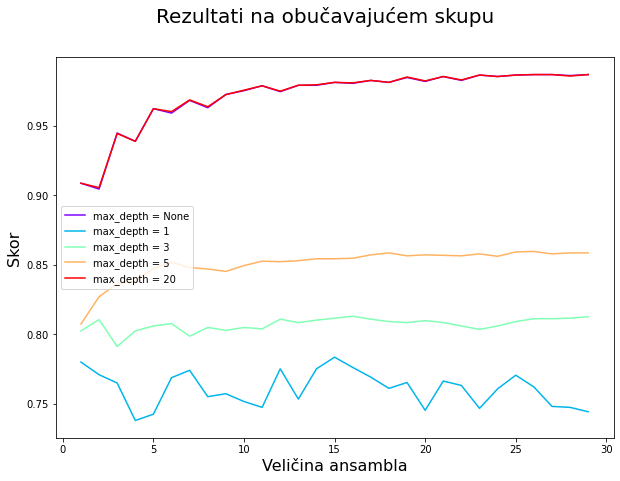

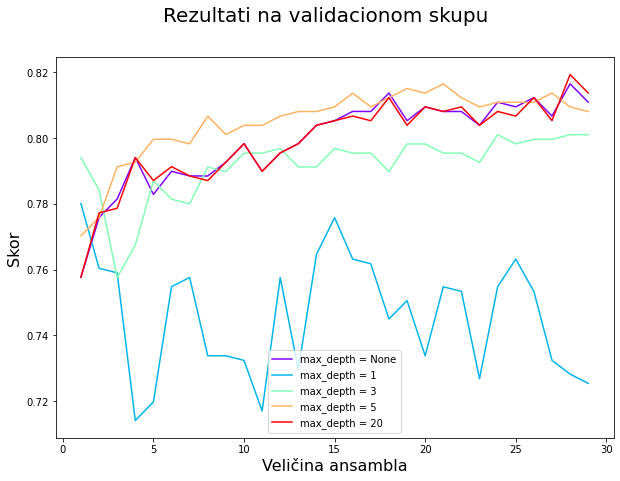

In [71]:
from sklearn.ensemble import RandomForestClassifier

estimators = np.arange(1,30)
max_depths = [None, 1 , 3, 5, 20]

plot_cross_validation_multiparam(X=X, y=y, model=RandomForestClassifier(criterion="entropy", 
                                                                        random_state = 42, 
                                                                        class_weight="balanced_subsample"),
                                 main_param_name='n_estimators', main_param_range=estimators,
                                 param_name="max_depth", param_range=max_depths, scoring="accuracy",
                                 fig_id = "311"
                                )

Sa slike se vidi da je maksimalna dubina 5 najbolji kandidat. Obzirom da su stabla veoma osetljiva, ponovićemo postupak za dubine koje imaju vrednost oko 5.

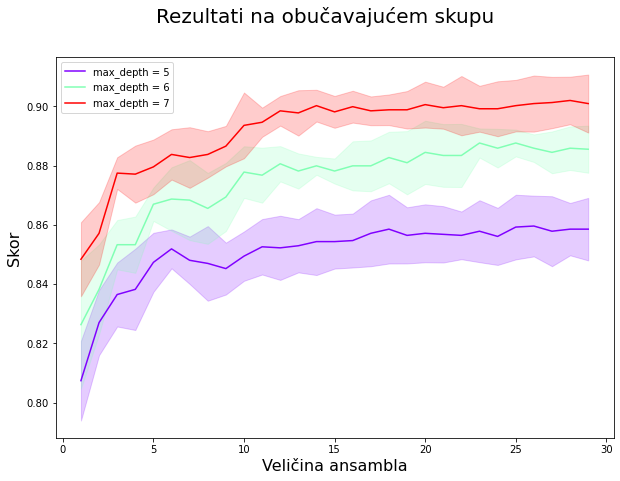

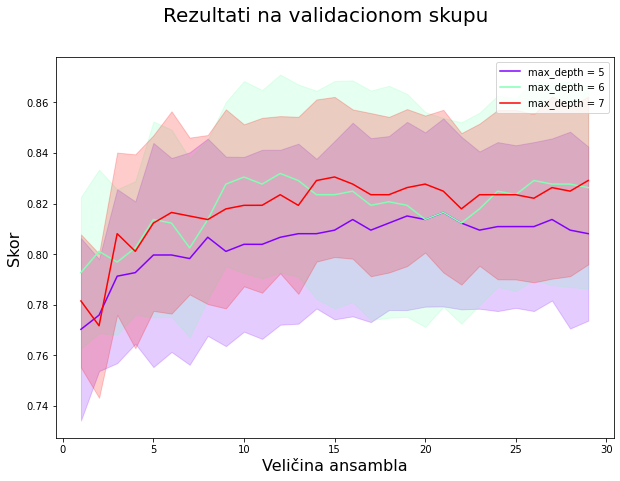

In [72]:
estimators = np.arange(1,30)
max_depths = [5, 6, 7]

plot_cross_validation_multiparam(X=X, y=y, model=RandomForestClassifier(criterion="entropy", 
                                                                        random_state = 42,
                                                                        class_weight="balanced_subsample"),
                                 main_param_name='n_estimators', main_param_range=estimators,
                                 param_name="max_depth", param_range=max_depths, scoring="accuracy",
                                 fig_id = "312", std=True
                                )

Sve tri maksimalne dubine daju dosta slične rezultate na validacionom skupu, ali se razlike na obučavajućem i validacionom značajno razlikuju. Pošto su velike maksimalne dubine dovele do mnogo većeg poboljšanja na obučavajućem skupu, ali jako malog na validacionom, to može da bude indikator da se tada dešava preobučavanje. 

Na osnovu ovoga kao optimalnu maksimalnu dubinu biramo 5.

### 3.1.2. Rezultati unakrsne validacije u zavisnosti od veličine ansambla za različite vrednosti maksimalnog broja odlika


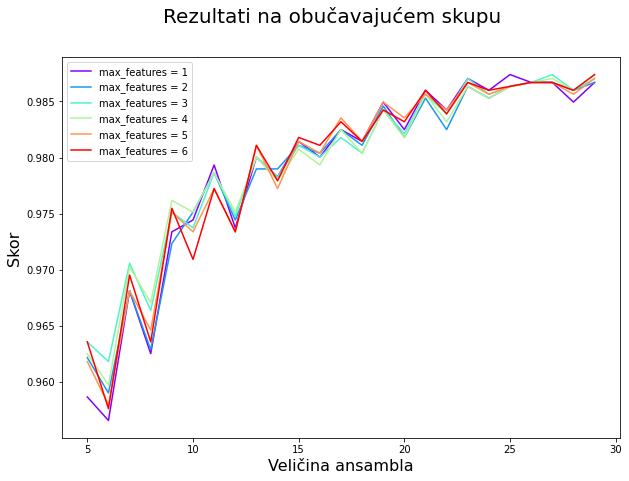

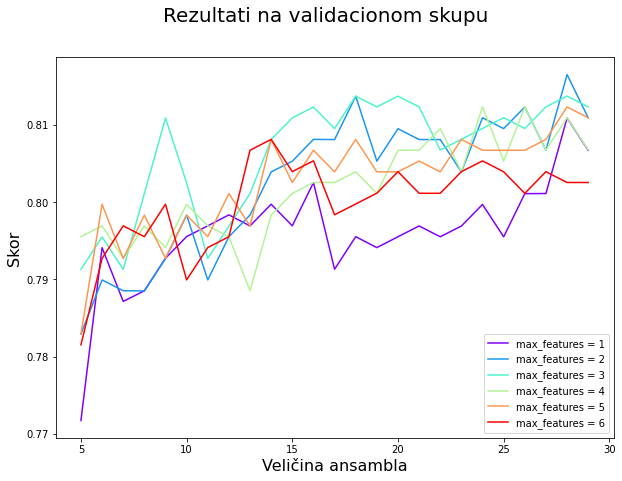

In [73]:
estimators = np.arange(5,30)
max_features = [1, 2, 3, 4, 5, 6]

plot_cross_validation_multiparam(X=X, y=y, model=RandomForestClassifier(criterion="entropy", 
                                                                        random_state = 42, 
                                                                        max_depth=None,
                                                                        class_weight="balanced_subsample"),
                                 main_param_name='n_estimators', main_param_range=estimators,
                                 param_name="max_features", param_range=max_features, scoring="accuracy",
                                 fig_id = "313"
                                )

Kada je broj obeležja manji nema smisla koristiti malu veličinu ansambla i rezultat je jako loš. Ovo je logično jer tada prosto najverovatnije nismo ni uzeli u obzir sve prediktore. Za veću veličinu ansambla vidimo da stabla koja koriste dva, tri ili četiri prediktora imaju mnogo bolje rezultate na validacionom skupu. Ovo je moglo i da se pretpostavi. Naime, ovaj metod se bazira na tome da ćemo grešku smanjiti jer će se greške različitih modela anulirati. Ipak, kada modeli koriste skoro sva ili sva obeležja koja su na raspolaganju oni postaju jako slični i samim tim njihove greške sve jače korelisane, pa agregacija rezultata više ne eliminiše grešku. 

Pogledajmo malo bolje situaciju u kojoj imamo 2,3 i 4 prediktora, sada sa optimalnom maksimalnom dubinom.

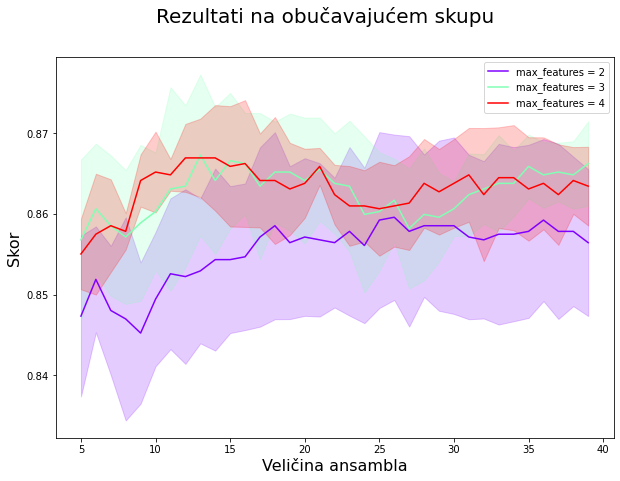

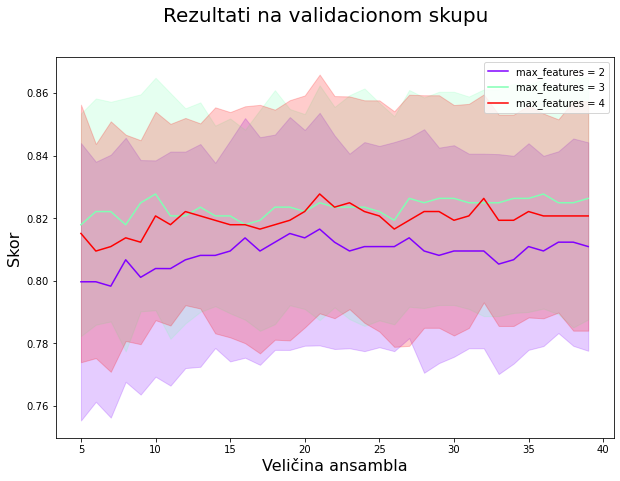

In [75]:
estimators = np.arange(5,40)
max_features = [2, 3, 4]

plot_cross_validation_multiparam(X=X, y=y, model=RandomForestClassifier(criterion="entropy", 
                                                                        random_state = 42, 
                                                                        max_depth=5,
                                                                        class_weight="balanced_subsample"),
                                 main_param_name='n_estimators', main_param_range=estimators,
                                 param_name="max_features", param_range=max_features, scoring="accuracy",
                                 fig_id = "314", std=True
                                )

Vidimo da su rezultati najbolji kada je veličina ansambla 10, a broj obeležja 3, sa maksimalnom dubinom 5.

### 3.1.3. Zakljucak

Dobijeni rezultati su upoređeni sa običnim klasifikacionim stablom i značajno su bolji. Ispod je prikazana matrica konfuzije sa optimalnim parametrima (mada ovo nije potpuno fer jer je ceo skup korišćen za unakrsnu validaciju). Tu možemo da vidimo da je veći deo greške posledica loše klasifikovanih odbiraka prve klase. 

In [79]:
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.12, random_state=42)

model = RandomForestClassifier(max_depth=5, max_features=3, n_estimators=25)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

confusion_matrix(y_test, y_pred)

array([[45,  7],
       [14, 20]], dtype=int64)

## 3.2. Gradient boosting

Ideja boosting algoritma je da se svaki naredni model pravi tako da nadomesti nedostatke prethodnih modela. 

### 3.2.1. Rezultati unakrsne validacije u zavisnosti od veličine ansambla za različite vrednosti maksimalne dubine stabla

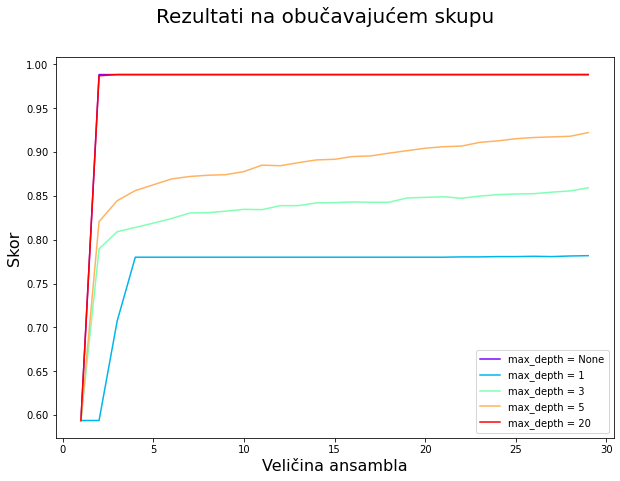

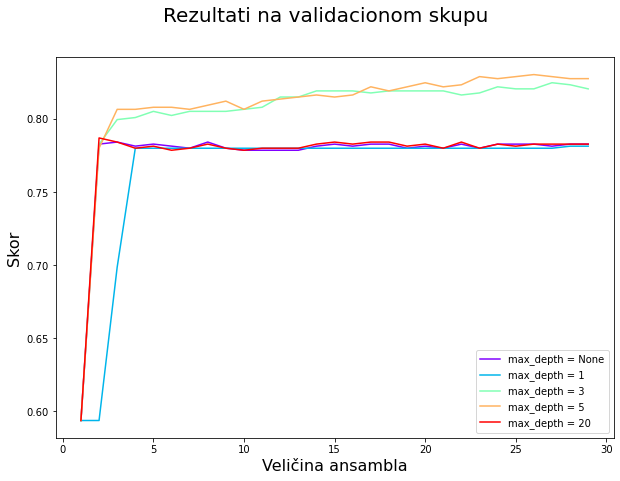

In [81]:
from sklearn.ensemble import GradientBoostingClassifier

estimators = np.arange(1,30)
max_depths = [None, 1 , 3, 5, 20]

plot_cross_validation_multiparam(X=X, y=y, model=GradientBoostingClassifier(loss = 'deviance', random_state = 42),
                                 main_param_name='n_estimators', main_param_range=estimators,
                                 param_name="max_depth", param_range=max_depths, scoring="accuracy",
                                 fig_id = "321"
                                )

Sa algoritmom slučajnih šuma su rezultati dosta nepregledni i jako teško procenjujemo kako se algoritam ponaša kada menjamo hiper-parametre. Ovde je to dosta očiglednije. Povećanje veličine ansambla na siguran način poboljšava perofrmanse algoritma i jasno je kada kriva uđe u zasićenje i dalje povećanje ne donosi poboljšanje. Ovo nije čudno - algoritam se bazira na tome da se svaki model poboljša tamo gde prethodni greše i samim tim, očigledno da će i tačnost da raste kako uvodimo nove modele. 

Vidimo da je parametar maksimalne dubine mnogo lakše odrediti. Jasno je da za pogrešnu vrednost ovog algoritma dolazimo do zasićenja koje je očigledno dosta manje od onog kada je maksimalna dubina blizu optimalne. 

Pogledajmo bolje šta se dešava kada je maksimalna dubina blizu vrednosti 5.

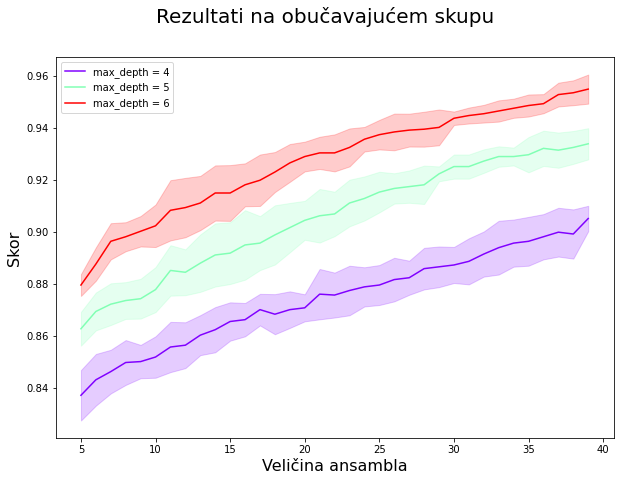

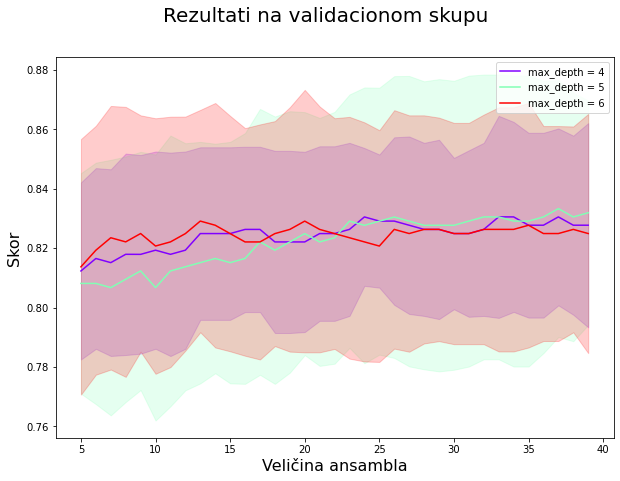

In [82]:
estimators = np.arange(5,40)
max_depths = [4, 5, 6]

plot_cross_validation_multiparam(X=X, y=y, model=GradientBoostingClassifier(loss = 'deviance',
                                                                            random_state = 42),
                                 main_param_name='n_estimators', main_param_range=estimators,
                                 param_name="max_depth", param_range=max_depths, scoring="accuracy",
                                 fig_id = "322", std=True
                                )

Ponovo imamo situaciju u kojoj su rezultati na validacionom skupu relativno slični, a dosta se razlikuju na obučavajućem skupu. Biramo onu dubinu za koju je rezultat na obučavajućem skupu najmanji jer je tu najmanje verovatno došlo do preobučavanja.

### 3.2.2. Rezultati unakrsne validacije u zavisnosti od veličine ansambla za različite vrednosti parametra učenja

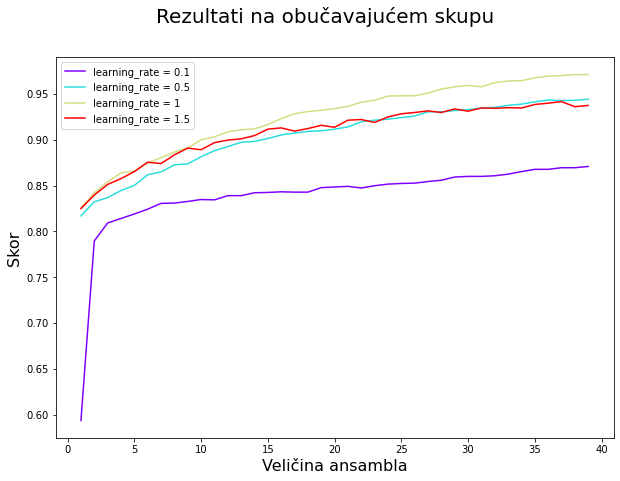

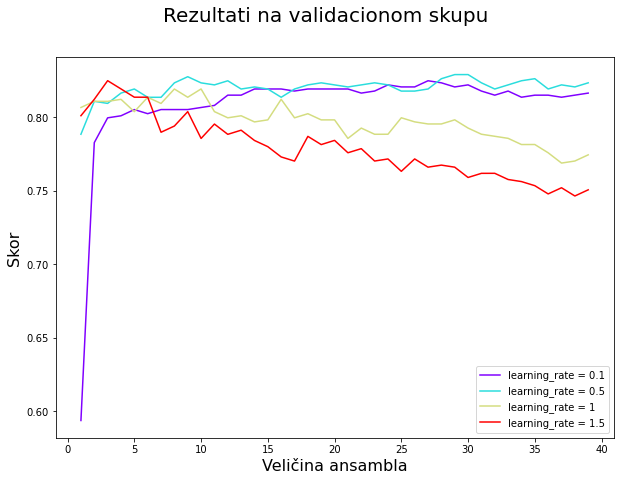

In [87]:
estimators = np.arange(1,40)
learning_rates = [0.1, 0.5, 1, 1.5]

plot_cross_validation_multiparam(X=X, y=y, model=GradientBoostingClassifier(loss = 'deviance', 
                                                                            random_state = 42),
                                 main_param_name='n_estimators', main_param_range=estimators,
                                 param_name="learning_rate", param_range=learning_rates, scoring="accuracy",
                                 fig_id = "323"
                                )

Očigledno, za veliki parametar učenja dolazi do preobučavanja. Najbolje rezultate dobijamo za parametre koji su između 0.1 i 0.5 pa ćemo ponovo pogledati detaljnije šta se dešava u toj situaciji, s tim da ćemo koristiti optimalnu maksimalnu dubinu.

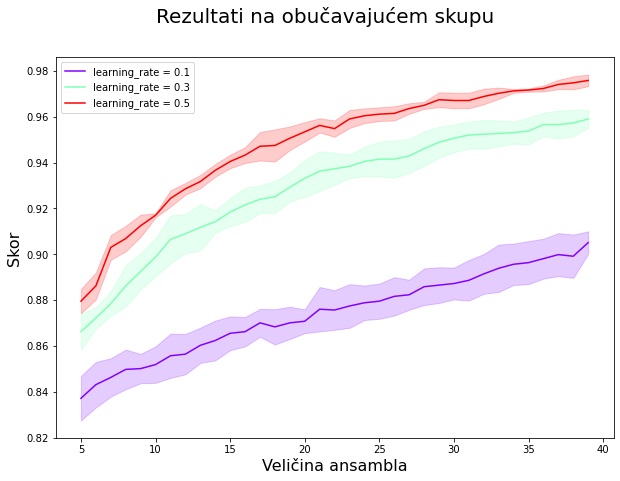

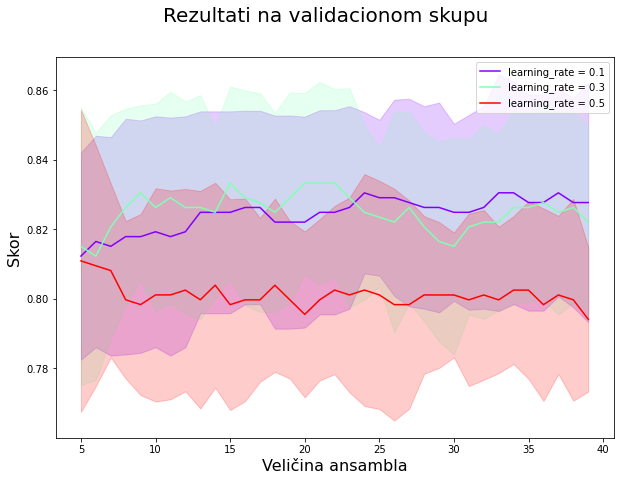

In [90]:
estimators = np.arange(5,40)
learning_rates = [0.1, 0.3, 0.5]

plot_cross_validation_multiparam(X=X, y=y, model=GradientBoostingClassifier(loss = 'deviance',
                                                                            random_state = 42,
                                                                            max_depth=4),
                                 main_param_name='n_estimators', main_param_range=estimators,
                                 param_name="learning_rate", param_range=learning_rates, scoring="accuracy",
                                 fig_id = "324", std=True
                                )

Vidimo da su rezultati najbolji za stopu učenja 0.3 i veličinu ansambla oko 10. Dalje povećanje veličine ansambla neće mnogo poboljšati validacionu krivu, ali hoće rezultate na obučavajućem skupu, dakle, najverovatnije da dolazi do preobučavanja. 

### 3.2.3. Zakljucak

Podešavanjem ovog modela uspeli smo da dobijemo sličnu tačnost kao i kod slučajnih šuma. 

In [91]:
model = GradientBoostingClassifier(loss = 'deviance',
                                   random_state = 42,
                                   max_depth=4, 
                                   learning_rate=0.3, 
                                   n_estimators=10)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

confusion_matrix(y_test, y_pred)

array([[42, 10],
       [13, 21]], dtype=int64)

## 3.3. Zakljucak

Ovi algoritmi daju mnogo bolje rezultate nego pojedinačni klasifikatori, a kada se koriste stabla odlučivanja ne moramo da brinemo o tome kakvog su tipa podaci. Iako se sa oba algoritma može postići slična tačnost, ono zbog čega gradijentno pojačanje deluje kao bolja opcija je mnogo lakše podešavanje hiper-parametra. Kolike god bile mogućnosti algoritma koji koristimo one ne znače ništa ako ih zapravo nismo iskoristili, a to je mnogo teže postići kada radimo sa slučajnim šumama. 

Dobijena tačnost vrlo verovatno nije najbolja moguća jer je jako teško proceniti odgovarajuće hiper-parametre, ali je na osnovu grafika rezultata unakrsne validacije moguće videti da je gornja granica u u najboljem slučaju prilično niska i da smo joj blizu. 
